# Objective:

Classify Amazon food reviews using Logistic Regression.

We'll do the following exercises in this notebook

* Load and standardize the data
        1. BoW
        2. Tfidf
        3. Avg. W2V
        4. Tfidf weighted W2V
* Divide the data in cross validation sets and find the optimal parameter using GridSearchCV.
* Gridseach on various values of parameter C, seperately for L1 and L2 regularization.
* Plot the Cross Validation Errors 
* Plot confusion matrix and calculate Precision, Recall, FPR, TNR, FNR. 



In [0]:
# To suprress the warnings as they make the notebook less presentable.

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Import the necessary libraries.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np

This Jupyter notebook extension notifies you when a cell finishes its execution!

In [0]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Important parameters of Logistic Regression 

* C = 1/lambda
* penalty i.e. regularization: L1/L2

Load the target variable y of train and test sets. Note that the entire dataset is being used. All 350k reviews. The dataset is divided into train and test with ratio 80:20 respectively.

In [0]:
#f = open(r'D:\data_science\datasets\amazon2\y_train_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_train_full80_20.pkl', 'rb')
y_train = pickle.load(f)
f.close()
print('The datatype of y_train is : {}'.format(type(y_train)))
print('The shape of y_train is : {}'.format(y_train.shape))

The datatype of y_train is : <class 'numpy.ndarray'>
The shape of y_train is : (291336,)


In [0]:
#f = open(r'D:\data_science\datasets\amazon2\y_test_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_test_full80_20.pkl', 'rb')
y_test = pickle.load(f)
f.close()
print('The datatype of y_test is : {}'.format(type(y_test)))
print('The shape of y_test is : {}'.format(y_test.shape))

The datatype of y_test is : <class 'numpy.ndarray'>
The shape of y_test is : (72835,)


## Bag of Words

I had saved the trained BoW model and the transformed data on disk. Let's load it. 

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_bow_full_nparray.pkl', 'rb')
X_train_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_bow is : {}'.format(type(X_train_transformed_bow)))
print('The shape of X_train_transformed_bow is : {}'.format(X_train_transformed_bow.shape))

The datatype of X_train_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_bow is : (291336, 64221)


There are 64221 features in the bow representation. Load test data too.

In [0]:
#f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_bow_full_nparray.pkl', 'rb')
X_test_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_bow is : {}'.format(type(X_test_transformed_bow)))
print('The shape of X_test_transformed_bow is : {}'.format(X_test_transformed_bow.shape))

The datatype of X_test_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_bow is : (72835, 64221)


Count the number of non-zero elements in the array.

In [0]:
X_train_transformed_bow.count_nonzero

<bound method _data_matrix.count_nonzero of <291336x64221 sparse matrix of type '<class 'numpy.int64'>'
	with 9180635 stored elements in Compressed Sparse Row format>>

## Feature scaling

Logistic regression is a distance based algorithm. Therefore, it's necessary to standardize the data.

In [0]:
scaler = StandardScaler(with_mean = False)
X_train_transformed_bow_std = scaler.fit_transform(X_train_transformed_bow)

In [0]:
X_test_transformed_bow_std = scaler.transform(X_test_transformed_bow)

## Multi-co-linearity Check - Perturbation Test

Function to check multi colinearity. First, we find the weights before perturbation is applied, and once again after perturbation is applied.

We add very small noise using the np.random.normal() function to only those cells in the grid X, which are non-zero.  We'll compare the weights before and after by calculating the percent change.

In [0]:
def check_multi_colinearity(X,y):
    
    log_reg_1 = LogisticRegression(penalty='l2', C=1.0)
    log_reg_1.fit(X,y)
    
    # coef_1 is 'w' in the LR formula
    coef_1 = log_reg_1.coef_
    
    X_PERTURBED = X.tocoo()
    
    X_PERTURBED.data += np.random.normal(0,0.5)
    
    log_reg_2 = LogisticRegression(penalty='l2', C=1.0)
    log_reg_2.fit(X_PERTURBED, y)
    
    coef_2 = log_reg_2.coef_

    return(coef_1, coef_2)

In [0]:
%%notify
%%time

coef_1, coef_2 = check_multi_colinearity(X_train_transformed_bow_std, y_train)
print('% change in mean of coef_ before and after perturbation: {}'.format(((np.mean(coef_1)-np.mean(coef_2))/np.mean(coef_1))*100))
print('% change in std of coef_ before and after perturbation: {}'.format(((np.std(coef_1)-np.std(coef_2))/np.std(coef_1))*100))

% change in mean of coef_ before and after perturbation: 5.286068950423912
% change in std of coef_ before and after perturbation: 0.1245067992618435
CPU times: user 12min 41s, sys: 9.75 s, total: 12min 51s
Wall time: 4min 17s


/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<IPython.core.display.Javascript object>

As can be seen above, the percent change in the mean and standard deviation of the coefficient was 5% and 0.124%, on one of the executions. I executed the code multiple times and the range varied between -5 to 5%. Which can't be considered a drastic change. 

So for the time being we can assume that the features are not corelated.

## Some Functions

Let's define some functions that we'll call repeatedly in this notebook. 

1. **c_vs_error** : For each value of C given to GridSearch, it will plot the error (i.e. 1 - accuracy) for train and test data. 

2. **give_me_ratios** : To plot ratios such as Precision, Recall, TNR, FPR, FNR.
3. **plot_confusion_matrix** : As the name says.
4. **GridSearch** : Create Time based cross validation splits using TimeSeriesSplit() and  create a gridsearch object for the regularization passed as a parameter. 

In [0]:
def c_vs_error(cv_results_, x_label, y_label, pen, title):
    
    mean_error_train = list(1 - clf.cv_results_['mean_train_score'])
    mean_error_test = list(1 - clf.cv_results_['mean_test_score'])
    
    c = [ 0.001, 0.01, 0.1, 1, 10, 100 ]
    
    df_train = pd.DataFrame({'CV error' : mean_error_train, 'C':c})
    df_test = pd.DataFrame({'CV error': mean_error_test, 'C':c})
    
    plt.figure(figsize=(15,6)).suptitle(title, fontsize=16)
    plt.subplot(1,2,1)
    sbn.barplot(data=df_train, x='C', y='CV error')
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)
    plt.title('Train data | penalty: {}'.format(pen), fontsize=15)
    
    plt.subplot(1,2,2)
    sbn.barplot(data=df_test, x= 'C', y='CV error')
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)
    plt.title('Test data | penalty: {}'.format(pen), fontsize=15)
    
    plt.tight_layout()
    plt.show()
    

In [0]:
def give_me_ratios(X_train, y_train, X_test, y_test, vector_type,penalty, table, clf): 
    
    cm_train = confusion_matrix(y_train, clf.predict(X_train))
    tn, fp, fn, tp = cm_train.ravel()

    recall_train = round(tp/(tp+fn),2)
    precision_train = round(tp/(tp+fp),2)
    tnr_train = round(tn/(tn+fp),2)
    fpr_train = round(fp/(fp+tn),2)
    fnr_train = round(fn/(fn+tp),2)
    accuracy_train = round((tp+tn)/(tp+tn+fp+fn))
    accuracy_train = (tp+tn)/(tp+tn+fp+fn)

    cm_test = confusion_matrix(y_test, clf.predict(X_test))
    tn, fp, fn, tp = cm_test.ravel()
    recall_test = round(tp/(tp+fn),2)
    precision_test = round(tp/(tp+fp),2)
    tnr_test = round(tn/(tn+fp),2)
    fpr_test = round(fp/(fp+tn),2)
    fnr_test = round(fn/(fn+tp),2)
    accuracy_test = round(tp+tn)/(tp+tn+fp+fn)

    table.field_names = ['Vector Type','penalty','Data Set', 'Precision', 'Recall', 'TNR', 'FPR', 'FNR', 'Accuracy']
    table.add_row([vector_type,penalty,'Train', precision_train, recall_train, tnr_train, fpr_train, fnr_train, accuracy_train])
    table.add_row([vector_type,penalty,'Test', precision_test, recall_test, tnr_test, fpr_test, fnr_test, accuracy_test])

    print(table)
    
    return (cm_train, cm_test)

In [0]:
def plot_confusion_matrix(cm_train, cm_test, title):
    
    import pandas as pd
    plt.figure(figsize=(15,6)).suptitle(title, fontsize=15)
    
    plt.subplot(1,2,1)
    df_cm = pd.DataFrame(cm_train, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    plt.ylabel('Actual Class', fontsize=15)
    plt.title('Train Data', fontsize = 14)

    plt.subplot(1,2,2)    
    df_cm = pd.DataFrame(cm_test, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    # plt.ylabel('Actual Class', fontsize=15)

    plt.title('Test Data', fontsize = 14)

    plt.tight_layout()

In [0]:
def GridSearch(X_train, pen):

    tscv = TimeSeriesSplit(n_splits=10)
    my_cv = tscv.split(X_train)

    lr = LogisticRegression(penalty=pen)

    hyp_par = {
                'C':[0.001, 0.01, 0.1, 10, 100, 1000]
        }

    clf = GridSearchCV(estimator=lr, cv=my_cv, param_grid=hyp_par, n_jobs=6, return_train_score=True)
    
    return clf

**GridSearchCV | BOW | L1 penalty**

Get the classifier by calling the GridSearch funtion

In [0]:
clf = GridSearch(X_train_transformed_bow_std, pen = 'l1')

Train the model

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_bow_std, y_train)

In [0]:
clf.best_params_

{'C': 0.01}

Plot errors during cross validation using the function we defined above.

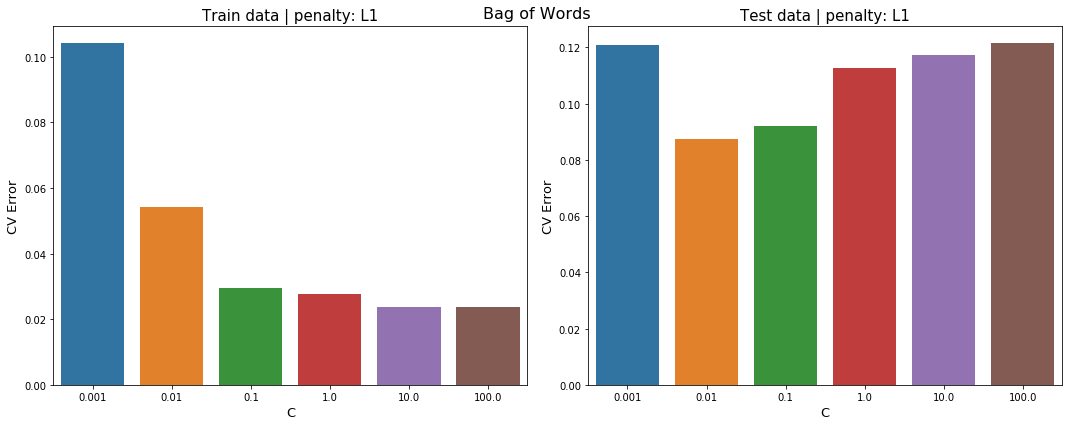

In [0]:
c_vs_error(clf.cv_results_, 'C', 'CV Error', pen='L1', title='Bag of Words')

Import prettytable to summarize the results in a table

In [0]:
# !pip install PrettyTable
# from prettytable import PrettyTable
from prettytable import PrettyTable
table = PrettyTable()

Calculate the ratios.

In [0]:
cm_bow_train, cm_bow_test = give_me_ratios(X_train_transformed_bow_std, y_train, X_test_transformed_bow_std, y_test, 'Bag of Words','L1', table, clf)

+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | penalty | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |    L1   |  Train   |    0.95   |  0.99  | 0.72 | 0.28 | 0.01 | 0.9456023285828047 |
| Bag of Words |    L1   |   Test   |    0.93   |  0.97  | 0.65 | 0.35 | 0.03 | 0.9152467906912886 |
+--------------+---------+----------+-----------+--------+------+------+------+--------------------+


Plot the confusion matrix.

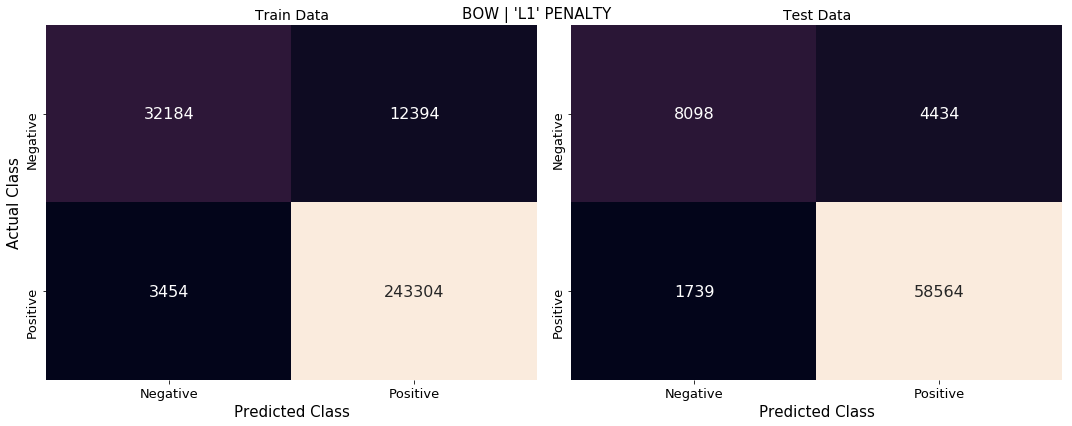

In [0]:
plot_confusion_matrix(cm_bow_train, cm_bow_test, title="BOW | 'L1' PENALTY")

**Grid search | BOW| L2 penalty**

Get the classifier and train the model.

In [0]:
clf = GridSearch(X_train_transformed_bow_std, pen='l2')

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_bow_std, y_train)

In [0]:
clf.best_params_

{'C': 0.001}

Plot CV errors

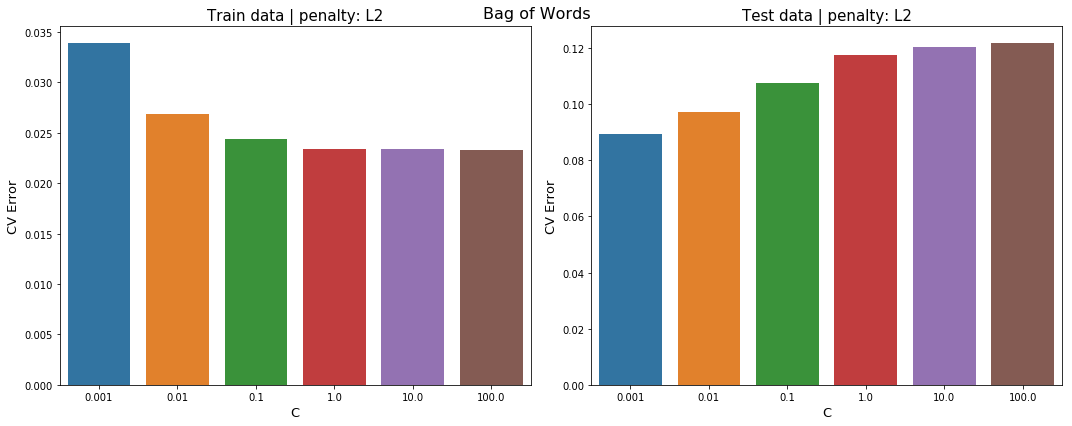

In [0]:
c_vs_error(clf.cv_results_, 'C', 'CV Error', pen='L2', title='Bag of Words')

Get ratios.

In [0]:
cm_bow_train, cm_bow_test = give_me_ratios(X_train_transformed_bow_std, y_train, X_test_transformed_bow_std, y_test, 'Bag of Words','L2', table, clf)

+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | penalty | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |    L1   |  Train   |    0.95   |  0.99  | 0.72 | 0.28 | 0.01 | 0.9456023285828047 |
| Bag of Words |    L1   |   Test   |    0.93   |  0.97  | 0.65 | 0.35 | 0.03 | 0.9152467906912886 |
| Bag of Words |    L2   |  Train   |    0.96   |  0.99  | 0.79 | 0.21 | 0.01 | 0.9555633358047066 |
| Bag of Words |    L2   |   Test   |    0.93   |  0.96  | 0.65 | 0.35 | 0.04 | 0.9086977414704469 |
+--------------+---------+----------+-----------+--------+------+------+------+--------------------+


Plot confusion matrix

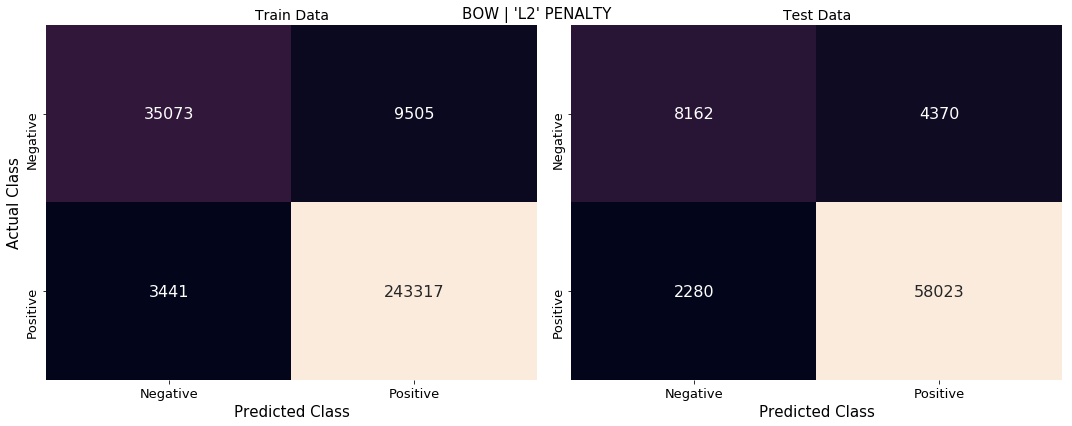

In [0]:
plot_confusion_matrix(cm_bow_train, cm_bow_test, "BOW | 'L2' PENALTY")

## Tfidf

In this section, we'll apply LR on reviews represented in the Tfidf format. Load the transformed train and test sets.

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_tfidf_full_nparray.pkl', 'rb')
X_train_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_tfidf is : {}'.format(type(X_train_transformed_tfidf)))
print('The shape of X_train_transformed_tfidf is : {}'.format(X_train_transformed_tfidf.shape))

The datatype of X_train_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_tfidf is : (291336, 64221)


In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_tfidf_full_nparray.pkl', 'rb')
X_test_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_tfidf is : {}'.format(type(X_test_transformed_tfidf)))
print('The shape of X_test_transformed_tfidf is : {}'.format(X_test_transformed_tfidf.shape))

The datatype of X_test_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_tfidf is : (72835, 64221)


Standardize data

In [0]:
scaler = StandardScaler(with_mean = False)
X_train_transformed_tfidf_std = scaler.fit_transform(X_train_transformed_tfidf)

In [0]:
X_test_transformed_tfidf_std = scaler.transform(X_test_transformed_tfidf)

**GridSearch | TFIDF | L1 penalty**

In [0]:
clf = GridSearch(X_train_transformed_tfidf_std, pen='l1')

Train the model

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_tfidf_std, y_train)

In [0]:
clf.best_params_

{'C': 0.01}

Plot CV errors

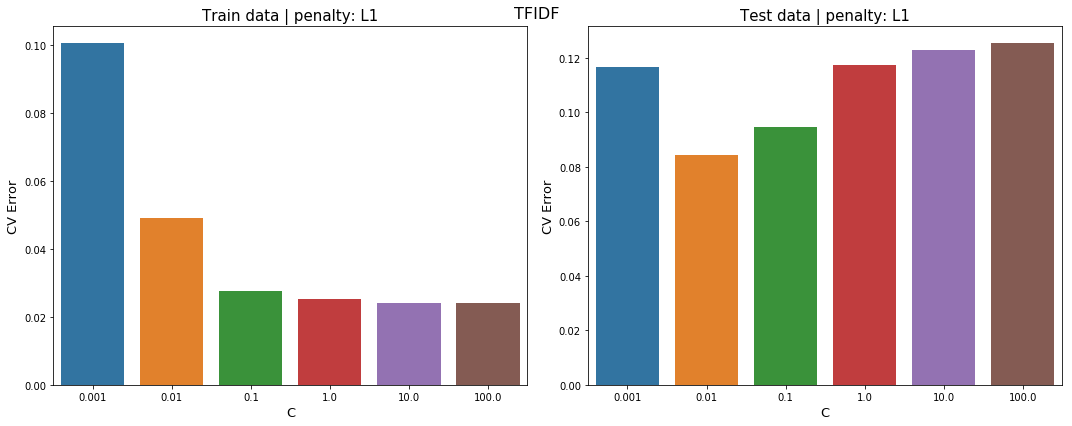

In [0]:
c_vs_error(clf.cv_results_, 'C', 'CV Error', pen='L1', title='TFIDF')

Create ratios

In [0]:
cm_tfidf_train, cm_tfidf_test = give_me_ratios(X_train_transformed_tfidf_std, y_train, X_test_transformed_tfidf_std, y_test, 'TFIDF','L1', table, clf)

+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | penalty | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |    L1   |  Train   |    0.95   |  0.99  | 0.72 | 0.28 | 0.01 | 0.9456023285828047 |
| Bag of Words |    L1   |   Test   |    0.93   |  0.97  | 0.65 | 0.35 | 0.03 | 0.9152467906912886 |
| Bag of Words |    L2   |  Train   |    0.96   |  0.99  | 0.79 | 0.21 | 0.01 | 0.9555633358047066 |
| Bag of Words |    L2   |   Test   |    0.93   |  0.96  | 0.65 | 0.35 | 0.04 | 0.9086977414704469 |
|    TFIDF     |    L1   |  Train   |    0.96   |  0.98  | 0.75 | 0.25 | 0.02 | 0.9487464645632534 |
|    TFIDF     |    L1   |   Test   |    0.93   |  0.97  | 0.66 | 0.34 | 0.03 | 0.9166472163108396 |
+--------------+---------+----------+-----------+--------+------+------+------+------------

Plot the confusion matrix.

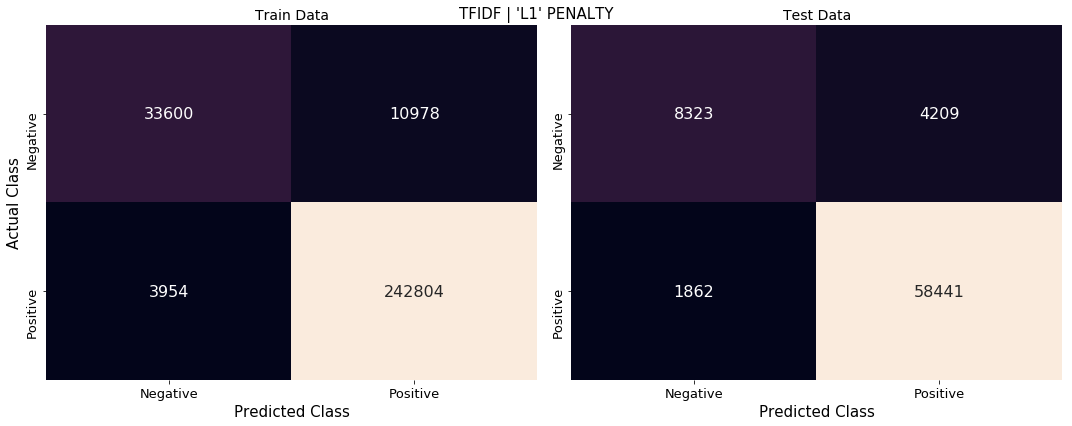

In [0]:
plot_confusion_matrix(cm_tfidf_train, cm_tfidf_test, "TFIDF | 'L1' PENALTY")

**GridSearch | TFIDF | L2 penalty**

In [0]:
clf = GridSearch(X_train_transformed_tfidf_std, pen='l2')

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_tfidf_std, y_train)

In [0]:
clf.best_params_

{'C': 0.001}

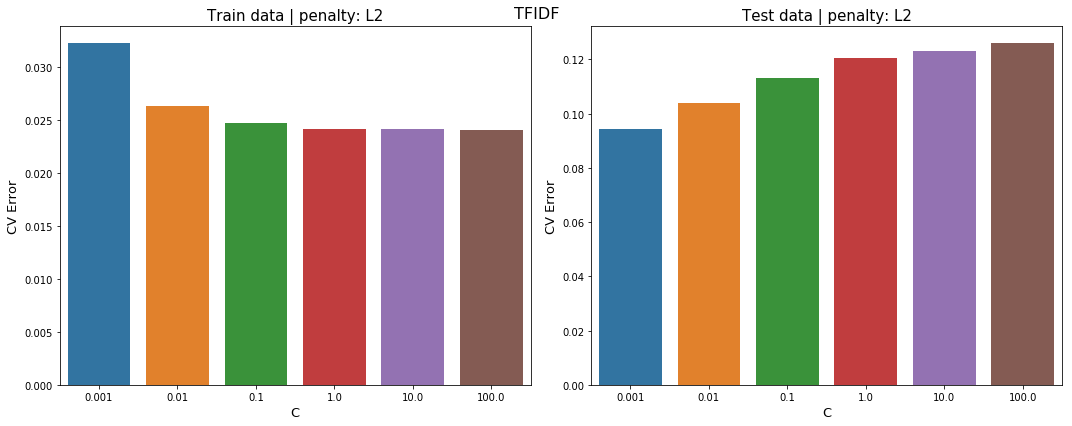

In [0]:
c_vs_error(clf.cv_results_, 'C', 'CV Error', pen='L2', title='TFIDF')

In [0]:
cm_tfidf_train, cm_tfidf_test = give_me_ratios(X_train_transformed_tfidf_std, y_train, X_test_transformed_tfidf_std, y_test, 'TFIDF','L2', table, clf)

+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | penalty | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |    L1   |  Train   |    0.95   |  0.99  | 0.72 | 0.28 | 0.01 | 0.9456023285828047 |
| Bag of Words |    L1   |   Test   |    0.93   |  0.97  | 0.65 | 0.35 | 0.03 | 0.9152467906912886 |
| Bag of Words |    L2   |  Train   |    0.96   |  0.99  | 0.79 | 0.21 | 0.01 | 0.9555633358047066 |
| Bag of Words |    L2   |   Test   |    0.93   |  0.96  | 0.65 | 0.35 | 0.04 | 0.9086977414704469 |
|    TFIDF     |    L1   |  Train   |    0.96   |  0.98  | 0.75 | 0.25 | 0.02 | 0.9487464645632534 |
|    TFIDF     |    L1   |   Test   |    0.93   |  0.97  | 0.66 | 0.34 | 0.03 | 0.9166472163108396 |
|    TFIDF     |    L2   |  Train   |    0.97   |  0.98  | 0.8  | 0.2  | 0.02 | 0.955800175

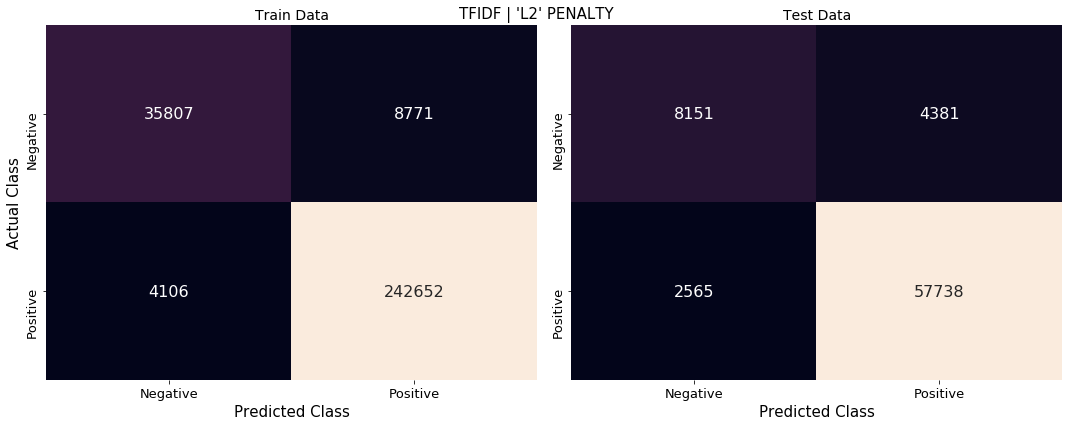

In [0]:
plot_confusion_matrix(cm_tfidf_train, cm_tfidf_test, "TFIDF | 'L2' PENALTY")

___________________________

## Avg W2V

In this section, we'll apply LR on data represented in the avg. W2V format.
load the train and test data stored on disk.

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_avgW2V is : {}'.format(type(X_test_transformed_avgW2V)))
print('The shape of X_test_transformed_avgW2V is : {}'.format(X_test_transformed_avgW2V.shape))

The datatype of X_test_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_test_transformed_avgW2V is : (72835, 50)


Standardize the data

In [0]:
scaler = StandardScaler(with_mean = True)
X_train_transformed_avgW2V_std = scaler.fit_transform(X_train_transformed_avgW2V)

In [0]:
X_test_transformed_avgW2V_std = scaler.transform(X_test_transformed_avgW2V)

**GridSearch | avg. W2V | L1 penalty**



In [0]:
clf = GridSearch(X_train_transformed_avgW2V_std, pen='l1')

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_avgW2V_std, y_train)

In [0]:
clf.best_params_

{'C': 100}

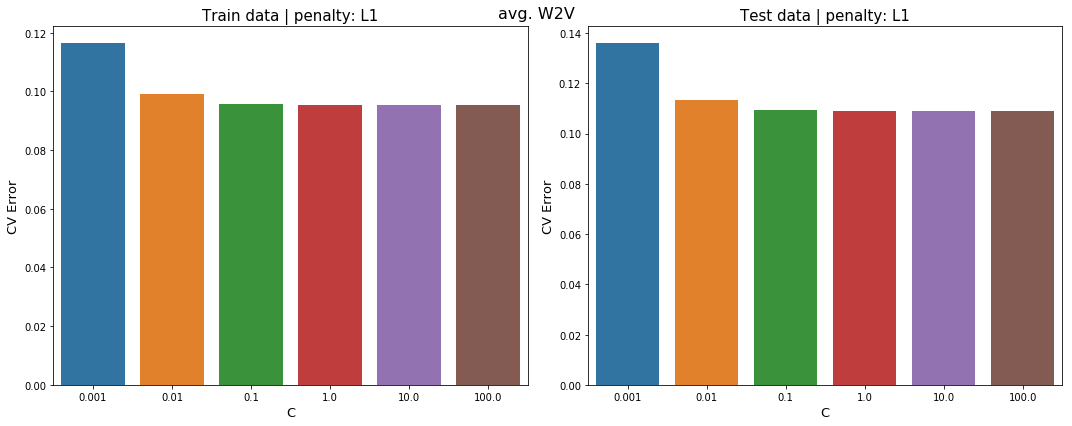

In [0]:
c_vs_error(clf.cv_results_, 'C', 'CV Error', pen='L1', title='avg. W2V')

Update the table with values of Avg. W2V.

In [0]:
cm_w2v_train, cm_w2v_test = give_me_ratios(X_train_transformed_avgW2V_std, y_train, X_test_transformed_avgW2V_std, y_test, 'avg. W2V','L1', table, clf)

+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | penalty | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |    L1   |  Train   |    0.95   |  0.99  | 0.72 | 0.28 | 0.01 | 0.9456023285828047 |
| Bag of Words |    L1   |   Test   |    0.93   |  0.97  | 0.65 | 0.35 | 0.03 | 0.9152467906912886 |
| Bag of Words |    L2   |  Train   |    0.96   |  0.99  | 0.79 | 0.21 | 0.01 | 0.9555633358047066 |
| Bag of Words |    L2   |   Test   |    0.93   |  0.96  | 0.65 | 0.35 | 0.04 | 0.9086977414704469 |
|    TFIDF     |    L1   |  Train   |    0.96   |  0.98  | 0.75 | 0.25 | 0.02 | 0.9487464645632534 |
|    TFIDF     |    L1   |   Test   |    0.93   |  0.97  | 0.66 | 0.34 | 0.03 | 0.9166472163108396 |
|    TFIDF     |    L2   |  Train   |    0.97   |  0.98  | 0.8  | 0.2  | 0.02 | 0.955800175

Plot the confusion matrix.

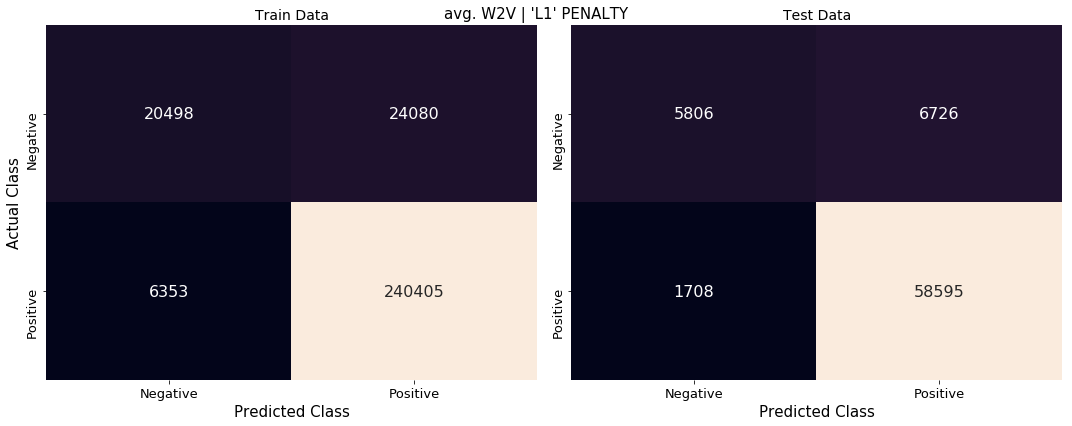

In [0]:
plot_confusion_matrix(cm_w2v_train, cm_w2v_test, "avg. W2V | 'L1' PENALTY")

**GridSearch | avg. W2V | L2 penalty**

In [0]:
clf = GridSearch(X_train_transformed_avgW2V_std, pen='l2')

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_avgW2V_std, y_train)

In [0]:
clf.best_params_

{'C': 10}

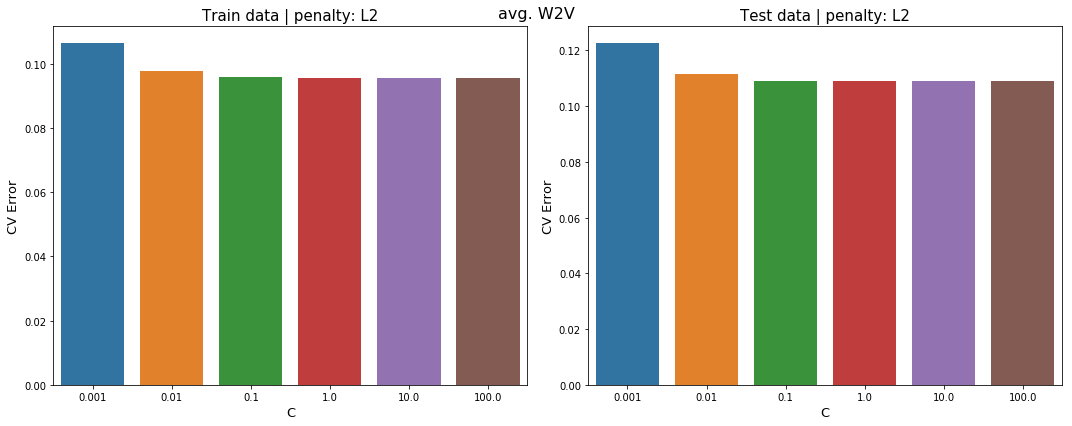

In [0]:
c_vs_error(clf.cv_results_, 'C', 'CV Error', pen='L2', title='avg. W2V')

In [0]:
cm_w2v_train, cm_w2v_test = give_me_ratios(X_train_transformed_avgW2V_std, y_train, X_test_transformed_avgW2V_std, y_test, 'avg. W2V','L2', table, clf)

+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | penalty | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+---------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |    L1   |  Train   |    0.95   |  0.99  | 0.72 | 0.28 | 0.01 | 0.9456023285828047 |
| Bag of Words |    L1   |   Test   |    0.93   |  0.97  | 0.65 | 0.35 | 0.03 | 0.9152467906912886 |
| Bag of Words |    L2   |  Train   |    0.96   |  0.99  | 0.79 | 0.21 | 0.01 | 0.9555633358047066 |
| Bag of Words |    L2   |   Test   |    0.93   |  0.96  | 0.65 | 0.35 | 0.04 | 0.9086977414704469 |
|    TFIDF     |    L1   |  Train   |    0.96   |  0.98  | 0.75 | 0.25 | 0.02 | 0.9487464645632534 |
|    TFIDF     |    L1   |   Test   |    0.93   |  0.97  | 0.66 | 0.34 | 0.03 | 0.9166472163108396 |
|    TFIDF     |    L2   |  Train   |    0.97   |  0.98  | 0.8  | 0.2  | 0.02 | 0.955800175

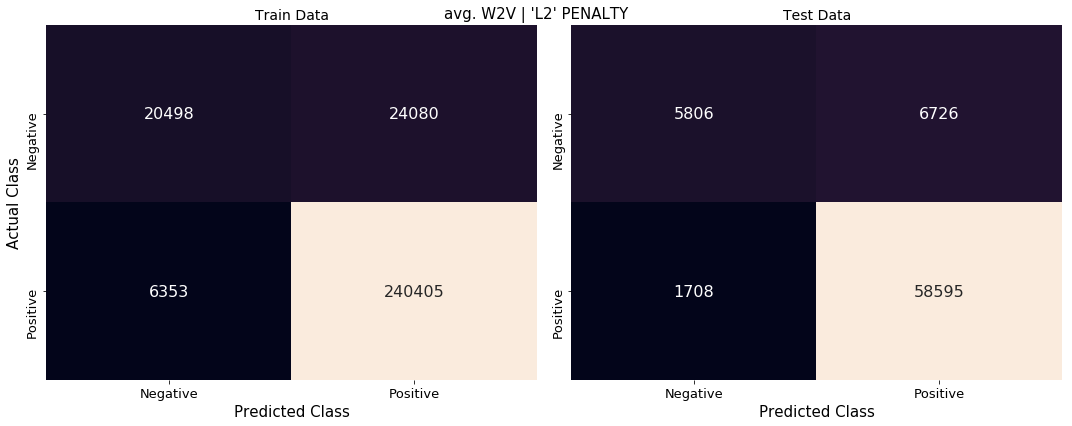

In [0]:
plot_confusion_matrix(cm_w2v_train, cm_w2v_test, "avg. W2V | 'L2' PENALTY")

## Tfidf weighted W2V

In this last section, we apply LR on vectors represented in the form of Tfidf weighted W2V.

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_TfidfW2V is : {}'.format(type(X_train_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_train_transformed_TfidfW2V.shape))

The datatype of X_train_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (291336, 50)


In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_TfidfW2V is : {}'.format(type(X_test_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_test_transformed_TfidfW2V.shape))

The datatype of X_test_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (72835, 50)


Standardize data

In [0]:
scaler = StandardScaler(with_mean = True)
X_train_transformed_TfidfW2V_std = scaler.fit_transform(X_train_transformed_TfidfW2V)

In [0]:
X_test_transformed_TfidfW2V_std = scaler.transform(X_test_transformed_TfidfW2V)

**GridSearch | Tfidf Weighted W2V | L1 penalty**

In [0]:
clf = GridSearch(X_train_transformed_TfidfW2V_std, pen='l1')

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_TfidfW2V_std, y_train)

In [0]:
clf.best_params_

{'C': 100}

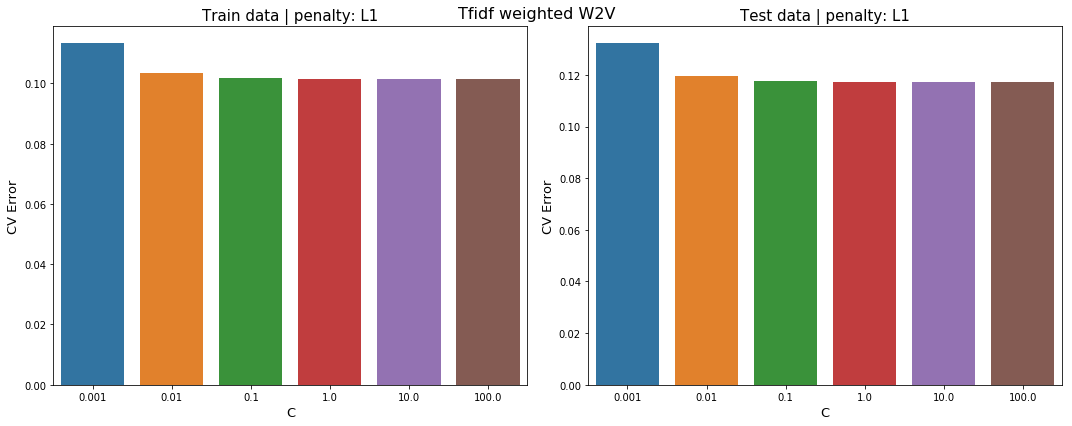

In [0]:
c_vs_error(clf.cv_results_, 'C', 'CV Error', pen='L1', title='Tfidf weighted W2V')

In [0]:
cm_tfidfw2v_train, cm_tfidfw2v_test = give_me_ratios(X_train_transformed_TfidfW2V_std, y_train, X_test_transformed_TfidfW2V_std, y_test, 'Tfidf weighted W2V','L1', table, clf)

+--------------------+---------+----------+-----------+--------+------+------+------+--------------------+
|    Vector Type     | penalty | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------------+---------+----------+-----------+--------+------+------+------+--------------------+
|    Bag of Words    |    L1   |  Train   |    0.95   |  0.99  | 0.72 | 0.28 | 0.01 | 0.9456023285828047 |
|    Bag of Words    |    L1   |   Test   |    0.93   |  0.97  | 0.65 | 0.35 | 0.03 | 0.9152467906912886 |
|    Bag of Words    |    L2   |  Train   |    0.96   |  0.99  | 0.79 | 0.21 | 0.01 | 0.9555633358047066 |
|    Bag of Words    |    L2   |   Test   |    0.93   |  0.96  | 0.65 | 0.35 | 0.04 | 0.9086977414704469 |
|       TFIDF        |    L1   |  Train   |    0.96   |  0.98  | 0.75 | 0.25 | 0.02 | 0.9487464645632534 |
|       TFIDF        |    L1   |   Test   |    0.93   |  0.97  | 0.66 | 0.34 | 0.03 | 0.9166472163108396 |
|       TFIDF        |    L2   |  Tra

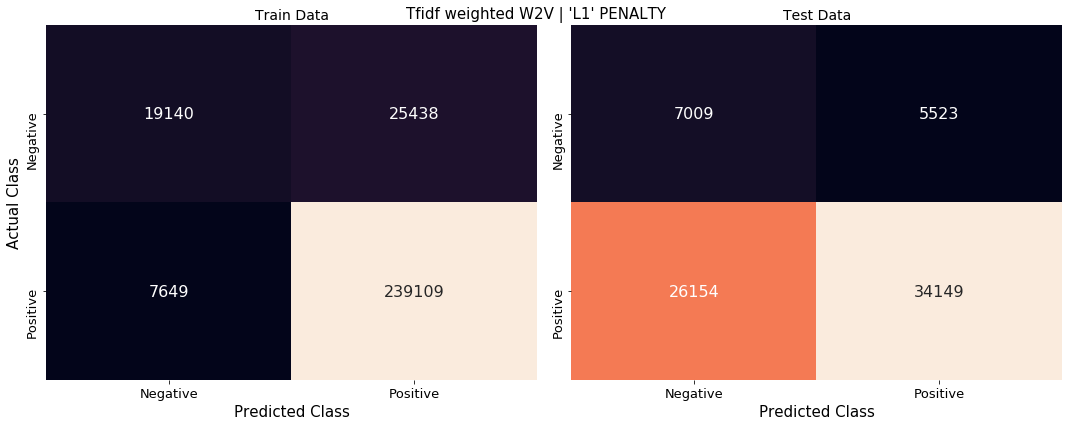

In [0]:
plot_confusion_matrix(cm_tfidfw2v_train, cm_tfidfw2v_test, "Tfidf weighted W2V | 'L1' PENALTY")

**GridSearch | Tfidf Weighted W2V | L2 penalty**

In [0]:
clf = GridSearch(X_train_transformed_TfidfW2V_std, pen='l2')

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_TfidfW2V_std, y_train)

In [0]:
clf.best_params_

{'C': 1000}

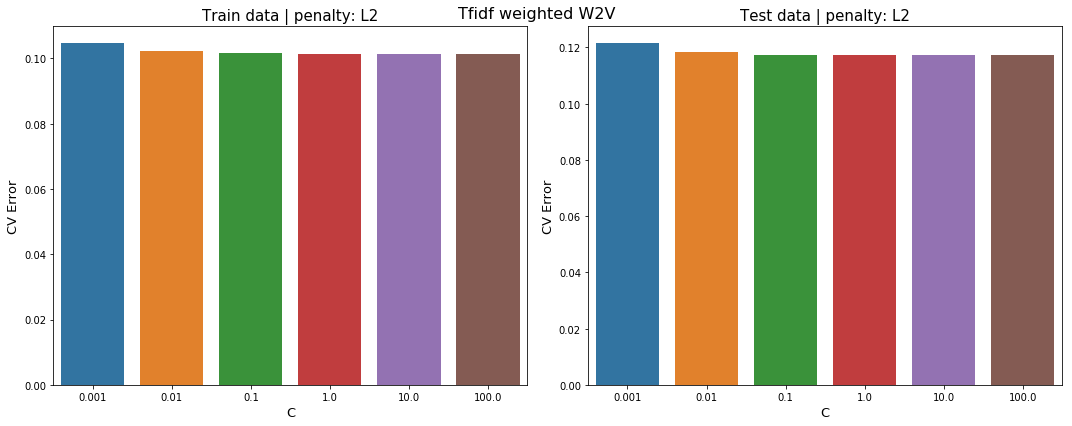

In [0]:
c_vs_error(clf.cv_results_, 'C', 'CV Error', pen='L2', title='Tfidf weighted W2V')

In [0]:
cm_tfidfw2v_train, cm_tfidfw2v_test = give_me_ratios(X_train_transformed_TfidfW2V_std, y_train, X_test_transformed_TfidfW2V_std, y_test, 'Tfidf weighted W2V','L2', table, clf)

+--------------------+---------+----------+-----------+--------+------+------+------+--------------------+
|    Vector Type     | penalty | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------------+---------+----------+-----------+--------+------+------+------+--------------------+
|    Bag of Words    |    L1   |  Train   |    0.95   |  0.99  | 0.72 | 0.28 | 0.01 | 0.9456023285828047 |
|    Bag of Words    |    L1   |   Test   |    0.93   |  0.97  | 0.65 | 0.35 | 0.03 | 0.9152467906912886 |
|    Bag of Words    |    L2   |  Train   |    0.96   |  0.99  | 0.79 | 0.21 | 0.01 | 0.9555633358047066 |
|    Bag of Words    |    L2   |   Test   |    0.93   |  0.96  | 0.65 | 0.35 | 0.04 | 0.9086977414704469 |
|       TFIDF        |    L1   |  Train   |    0.96   |  0.98  | 0.75 | 0.25 | 0.02 | 0.9487464645632534 |
|       TFIDF        |    L1   |   Test   |    0.93   |  0.97  | 0.66 | 0.34 | 0.03 | 0.9166472163108396 |
|       TFIDF        |    L2   |  Tra

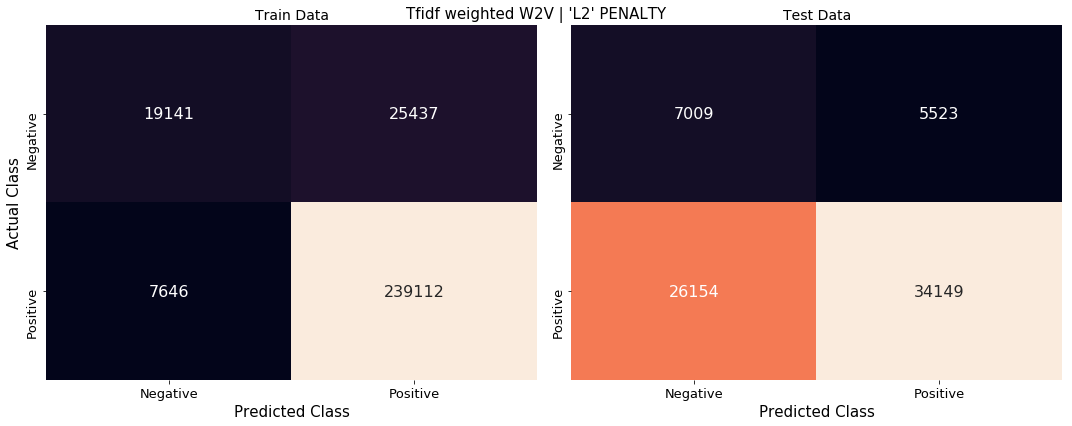

In [0]:
plot_confusion_matrix(cm_tfidfw2v_train, cm_tfidfw2v_test, "Tfidf weighted W2V | 'L2' PENALTY")

### Conclusion:

* We applied LR with regularization on amazon food reviews for various vector representations.

* The consolidated summary of various ratios can be found in the table above.
